In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sklearn as sk
import pandas
import numpy as np
import tensorflow as tf
import random
import os
import collections
import math
import time
import datetime
from tensorflow.contrib import learn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from matplotlib import pylab, pyplot

# Allow print picture or graph in Ipython
%matplotlib inline
# Allow print all arry if command print called
np.set_printoptions(threshold=np.inf)

In [2]:
from load_data import load_file, separate_data_label, label_encoding

In [3]:
from text_cnn import TextCNN

In [4]:
# Load classified Document
document1 = load_file("2007ChallengeTrainData.xml")
id_doc1, labels, words1 = separate_data_label(document1)

In [5]:
# Encoding words by one-hot encoding
max_document_length = max([len(x.split(" ")) for x in words1])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(words1)))

In [6]:
# One-hot-encoding label of each document
# There are 978 documents and 45 labels
y = label_encoding(labels, False)                                      # Encode data Label in DataFrame type
y = y.as_matrix()                                                      # Convert DataFrame type to numpy array 

In [7]:
y = label_encoding(labels, False)                                      # Encode data Label in DataFrame type
y = y.as_matrix() 

In [8]:
# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

In [9]:
# Split train/test set
# TODO: This is very crude, should use cross-validation
# split data into training (80%) and test (20%)
x_train, x_dev = train_test_split(x_shuffled, train_size = 0.8)
y_train, y_dev = train_test_split(y_shuffled, train_size = 0.8)
print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

Vocabulary Size: 1551
Train/Dev split: 782/196


In [10]:
embedding_dim = 128
filter_sizes = [3, 4, 5]
num_filters = 128
dropout_keep_prob = 0.5
l2_reg_lambda = 0.0
batch_size = 64
num_epochs = 200
evaluate_every = 100
checkpoint_every = 100

In [11]:
# Training
# ==================================================
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=True,
      log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=len(y[0]),
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=embedding_dim,
            filter_sizes=filter_sizes,
            num_filters=num_filters,
            l2_reg_lambda=l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.merge_summary(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.scalar_summary("loss", cnn.loss)
        acc_summary = tf.scalar_summary("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.merge_summary([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.train.SummaryWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.merge_summary([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.train.SummaryWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        #if not os.path.exists(checkpoint_dir):
        #    os.makedirs(checkpoint_dir)
        #saver = tf.train.Saver(tf.all_variables())

        # Store vocabulary embedded
        #dictionary.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.initialize_all_variables())

Writing to /home/ubuntu/workspace/tensorflow/Trying_example/runs/1474858523



In [12]:
# Sort each data and label into one pair
# then shuffle to ensure randomness 
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [13]:
batches = batch_iter(
        list(zip(x_train, y_train)), batch_size, num_epochs)

In [14]:
step_store = []
accuracy_store = []
eval_step = []
eval_accuracy = []
eval_precision = []
eval_recall = []
eval_f1 = []

In [15]:
def train_step(x_batch, y_batch):
    """
    A single training step
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: dropout_keep_prob
    }
    _, step, summaries, loss, accuracy = sess.run(
        [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
        feed_dict)
    step_store.append(step)
    accuracy_store.append(accuracy)
    print("step {}, loss {:g}, acc {:g}".format(step, loss, accuracy))
    train_summary_writer.add_summary(summaries, step)

In [16]:
def dev_step(x_batch, y_batch, writer=None):
    """
    Evaluates model on a dev set
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: 1.0
    }
    step, summaries, loss, accuracy, y_p = sess.run(
        [global_step, dev_summary_op, cnn.loss, cnn.accuracy, cnn.y_p],
        feed_dict)
    eval_step.append(step)
    eval_accuracy.append(accuracy)
    y_true = np.argmax(y_dev,1)
    precision = sk.metrics.precision_score(y_true, y_p)
    recall = sk.metrics.recall_score(y_true, y_p)
    f1_score = sk.metrics.f1_score(y_true, y_p)
    eval_precision.append(precision)
    eval_recall.append(recall)
    eval_f1.append(f1_score)
    print("step {}, loss {:g}, acc {:g}, precison {}, recall {}, f1_score {}.".format(step, loss, accuracy, precision, recall, f1_score))

In [17]:
for batch in batches:
    x_batch, y_batch = zip(*batch)
    train_step(x_batch, y_batch)
    current_step = tf.train.global_step(sess, global_step)
    if current_step % evaluate_every == 0:
        print("\nEvaluation:")
        dev_step(x_dev, y_dev, writer=dev_summary_writer)
        print("")

step 1, loss 8.16287, acc 0.015625
step 2, loss 6.82677, acc 0.109375
step 3, loss 4.29498, acc 0.21875
step 4, loss 3.90325, acc 0.265625
step 5, loss 3.62624, acc 0.34375
step 6, loss 3.61798, acc 0.296875
step 7, loss 3.03549, acc 0.328125
step 8, loss 2.70238, acc 0.453125
step 9, loss 2.19828, acc 0.546875
step 10, loss 3.71208, acc 0.40625
step 11, loss 2.59023, acc 0.40625
step 12, loss 3.18718, acc 0.46875
step 13, loss 3.09678, acc 0.357143
step 14, loss 2.38173, acc 0.421875
step 15, loss 2.1279, acc 0.453125
step 16, loss 2.51365, acc 0.40625
step 17, loss 2.3844, acc 0.453125
step 18, loss 3.01229, acc 0.390625
step 19, loss 2.42866, acc 0.453125
step 20, loss 2.54011, acc 0.375
step 21, loss 2.98356, acc 0.40625
step 22, loss 2.53317, acc 0.5
step 23, loss 2.64016, acc 0.375
step 24, loss 2.80957, acc 0.421875
step 25, loss 2.09508, acc 0.4375
step 26, loss 2.85116, acc 0.428571
step 27, loss 2.56665, acc 0.5
step 28, loss 2.81977, acc 0.421875
step 29, loss 1.84887, acc 0

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None wil

step 100, loss 1.52118, acc 0.44898, precison 0.382787325456, recall 0.448979591837, f1_score 0.411060404061.

step 101, loss 1.14629, acc 0.640625
step 102, loss 1.07238, acc 0.578125
step 103, loss 1.0792, acc 0.671875
step 104, loss 1.15063, acc 0.428571
step 105, loss 1.11278, acc 0.6875
step 106, loss 0.877591, acc 0.71875
step 107, loss 1.39326, acc 0.546875
step 108, loss 1.4875, acc 0.578125
step 109, loss 0.960945, acc 0.671875
step 110, loss 1.05957, acc 0.671875
step 111, loss 0.976901, acc 0.71875
step 112, loss 1.04512, acc 0.625
step 113, loss 1.0775, acc 0.6875
step 114, loss 1.16113, acc 0.625
step 115, loss 1.37954, acc 0.53125
step 116, loss 1.00182, acc 0.671875
step 117, loss 1.23377, acc 0.714286
step 118, loss 0.818541, acc 0.703125
step 119, loss 1.22364, acc 0.578125
step 120, loss 0.90779, acc 0.703125
step 121, loss 1.0097, acc 0.640625
step 122, loss 1.2906, acc 0.59375
step 123, loss 0.834434, acc 0.6875
step 124, loss 0.728637, acc 0.71875
step 125, loss 1.

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 200, loss 1.43276, acc 0.459184, precison 0.393451414657, recall 0.459183673469, f1_score 0.423666704251.

step 201, loss 0.591427, acc 0.765625
step 202, loss 0.509106, acc 0.796875
step 203, loss 0.607438, acc 0.75
step 204, loss 0.737028, acc 0.71875
step 205, loss 0.588476, acc 0.78125
step 206, loss 0.437324, acc 0.78125
step 207, loss 0.994625, acc 0.5625
step 208, loss 0.437118, acc 0.857143
step 209, loss 0.510355, acc 0.78125
step 210, loss 0.642014, acc 0.78125
step 211, loss 0.600892, acc 0.765625
step 212, loss 0.656784, acc 0.734375
step 213, loss 0.713867, acc 0.765625
step 214, loss 0.552792, acc 0.765625
step 215, loss 0.582407, acc 0.765625
step 216, loss 0.569683, acc 0.78125
step 217, loss 0.66613, acc 0.703125
step 218, loss 0.517915, acc 0.796875
step 219, loss 0.715046, acc 0.703125
step 220, loss 0.503665, acc 0.8125
step 221, loss 0.47529, acc 0.857143
step 222, loss 0.623547, acc 0.78125
step 223, loss 0.512063, acc 0.828125
step 224, loss 0.448453, acc 0.

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 300, loss 1.60198, acc 0.443878, precison 0.382301235987, recall 0.44387755102, f1_score 0.401755852843.

step 301, loss 0.387906, acc 0.859375
step 302, loss 0.44429, acc 0.875
step 303, loss 0.300162, acc 0.875
step 304, loss 0.499023, acc 0.8125
step 305, loss 0.428642, acc 0.859375
step 306, loss 0.461671, acc 0.859375
step 307, loss 0.257413, acc 0.890625
step 308, loss 0.492235, acc 0.84375
step 309, loss 0.659882, acc 0.75
step 310, loss 0.487097, acc 0.78125
step 311, loss 0.326414, acc 0.859375
step 312, loss 0.263253, acc 0.857143
step 313, loss 0.302236, acc 0.90625
step 314, loss 0.367862, acc 0.875
step 315, loss 0.2481, acc 0.921875
step 316, loss 0.653111, acc 0.75
step 317, loss 0.337771, acc 0.9375
step 318, loss 0.54003, acc 0.796875
step 319, loss 0.194616, acc 0.90625
step 320, loss 0.266244, acc 0.875
step 321, loss 0.313751, acc 0.890625
step 322, loss 0.262503, acc 0.890625
step 323, loss 0.297032, acc 0.875
step 324, loss 0.605686, acc 0.8125
step 325, loss

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 400, loss 1.66812, acc 0.438776, precison 0.374207039892, recall 0.438775510204, f1_score 0.403847702641.

step 401, loss 0.252129, acc 0.9375
step 402, loss 0.301146, acc 0.859375
step 403, loss 0.210375, acc 0.928571
step 404, loss 0.357005, acc 0.828125
step 405, loss 0.241919, acc 0.9375
step 406, loss 0.463708, acc 0.859375
step 407, loss 0.210891, acc 0.953125
step 408, loss 0.245438, acc 0.90625
step 409, loss 0.259217, acc 0.90625
step 410, loss 0.226664, acc 0.921875
step 411, loss 0.366937, acc 0.84375
step 412, loss 0.288881, acc 0.859375
step 413, loss 0.245595, acc 0.90625
step 414, loss 0.228835, acc 0.921875
step 415, loss 0.258628, acc 0.90625
step 416, loss 0.121631, acc 0.928571
step 417, loss 0.27593, acc 0.90625
step 418, loss 0.241886, acc 0.921875
step 419, loss 0.293165, acc 0.875
step 420, loss 0.22495, acc 0.9375
step 421, loss 0.493473, acc 0.90625
step 422, loss 0.184801, acc 0.953125
step 423, loss 0.50907, acc 0.859375
step 424, loss 0.265798, acc 0.87

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 500, loss 1.81285, acc 0.438776, precison 0.380749676182, recall 0.438775510204, f1_score 0.388161838162.

step 501, loss 0.360431, acc 0.859375
step 502, loss 0.160162, acc 0.96875
step 503, loss 0.130456, acc 0.96875
step 504, loss 0.147726, acc 0.984375
step 505, loss 0.210801, acc 0.953125
step 506, loss 0.342957, acc 0.921875
step 507, loss 0.115131, acc 1
step 508, loss 0.17077, acc 0.953125
step 509, loss 0.186236, acc 0.9375
step 510, loss 0.153124, acc 0.96875
step 511, loss 0.210806, acc 0.921875
step 512, loss 0.207751, acc 0.90625
step 513, loss 0.160107, acc 0.953125
step 514, loss 0.405494, acc 0.84375
step 515, loss 0.231455, acc 0.921875
step 516, loss 0.259701, acc 0.875
step 517, loss 0.163375, acc 0.9375
step 518, loss 0.187217, acc 0.921875
step 519, loss 0.24706, acc 0.890625
step 520, loss 0.0980914, acc 1
step 521, loss 0.152194, acc 0.9375
step 522, loss 0.28984, acc 0.921875
step 523, loss 0.12815, acc 0.953125
step 524, loss 0.128294, acc 0.9375
step 525,

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 600, loss 1.76066, acc 0.418367, precison 0.358179209184, recall 0.418367346939, f1_score 0.375574991902.

step 601, loss 0.18406, acc 0.953125
step 602, loss 0.11166, acc 0.96875
step 603, loss 0.121611, acc 0.96875
step 604, loss 0.250381, acc 0.921875
step 605, loss 0.180451, acc 0.921875
step 606, loss 0.116141, acc 0.96875
step 607, loss 0.223368, acc 0.890625
step 608, loss 0.110085, acc 0.96875
step 609, loss 0.108031, acc 0.9375
step 610, loss 0.193844, acc 0.96875
step 611, loss 0.151086, acc 1
step 612, loss 0.164459, acc 0.953125
step 613, loss 0.224919, acc 0.9375
step 614, loss 0.102023, acc 0.984375
step 615, loss 0.142597, acc 0.9375
step 616, loss 0.108402, acc 0.984375
step 617, loss 0.129763, acc 0.96875
step 618, loss 0.10258, acc 0.984375
step 619, loss 0.150502, acc 0.90625
step 620, loss 0.17906, acc 0.953125
step 621, loss 0.199198, acc 0.953125
step 622, loss 0.0955852, acc 0.953125
step 623, loss 0.0979483, acc 0.953125
step 624, loss 0.0532747, acc 1
step

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 700, loss 1.81777, acc 0.438776, precison 0.374982936318, recall 0.438775510204, f1_score 0.403748377426.

step 701, loss 0.0634132, acc 0.984375
step 702, loss 0.0584047, acc 1
step 703, loss 0.229247, acc 0.921875
step 704, loss 0.127922, acc 0.953125
step 705, loss 0.109429, acc 0.9375
step 706, loss 0.119364, acc 0.984375
step 707, loss 0.125491, acc 0.96875
step 708, loss 0.139343, acc 0.953125
step 709, loss 0.105119, acc 0.984375
step 710, loss 0.107709, acc 0.96875
step 711, loss 0.0875385, acc 0.984375
step 712, loss 0.168653, acc 0.9375
step 713, loss 0.0843541, acc 1
step 714, loss 0.155764, acc 0.9375
step 715, loss 0.152423, acc 0.928571
step 716, loss 0.0700961, acc 0.984375
step 717, loss 0.132057, acc 0.9375
step 718, loss 0.151328, acc 0.90625
step 719, loss 0.123983, acc 0.953125
step 720, loss 0.0607534, acc 1
step 721, loss 0.115761, acc 0.953125
step 722, loss 0.176275, acc 0.9375
step 723, loss 0.123711, acc 0.96875
step 724, loss 0.104926, acc 0.96875
step 7

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 800, loss 1.84934, acc 0.418367, precison 0.360090702948, recall 0.418367346939, f1_score 0.383479010833.

step 801, loss 0.0866016, acc 0.96875
step 802, loss 0.121764, acc 0.96875
step 803, loss 0.0676051, acc 0.96875
step 804, loss 0.0653807, acc 0.984375
step 805, loss 0.03263, acc 1
step 806, loss 0.212614, acc 0.928571
step 807, loss 0.0844545, acc 0.96875
step 808, loss 0.0827899, acc 0.984375
step 809, loss 0.14183, acc 0.9375
step 810, loss 0.130486, acc 0.953125
step 811, loss 0.0660152, acc 1
step 812, loss 0.102119, acc 0.96875
step 813, loss 0.0742298, acc 0.953125
step 814, loss 0.138082, acc 0.921875
step 815, loss 0.121659, acc 0.953125
step 816, loss 0.0542351, acc 0.984375
step 817, loss 0.0553175, acc 0.984375
step 818, loss 0.05492, acc 1
step 819, loss 0.0164769, acc 1
step 820, loss 0.0953089, acc 0.96875
step 821, loss 0.0861249, acc 0.984375
step 822, loss 0.119, acc 0.96875
step 823, loss 0.0944248, acc 0.984375
step 824, loss 0.115981, acc 0.984375
step 8

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 900, loss 1.84644, acc 0.423469, precison 0.361587087665, recall 0.423469387755, f1_score 0.38912598474.

step 901, loss 0.0526541, acc 0.984375
step 902, loss 0.0529098, acc 1
step 903, loss 0.0637975, acc 0.984375
step 904, loss 0.072031, acc 0.984375
step 905, loss 0.0621585, acc 1
step 906, loss 0.158111, acc 0.953125
step 907, loss 0.0956448, acc 0.984375
step 908, loss 0.0478002, acc 1
step 909, loss 0.0851481, acc 0.953125
step 910, loss 0.0596314, acc 1
step 911, loss 0.0644292, acc 0.984375
step 912, loss 0.0678476, acc 0.96875
step 913, loss 0.0773346, acc 0.96875
step 914, loss 0.0721986, acc 0.96875
step 915, loss 0.0786649, acc 0.96875
step 916, loss 0.0667323, acc 0.96875
step 917, loss 0.0952704, acc 0.96875
step 918, loss 0.0309418, acc 1
step 919, loss 0.0532148, acc 0.984375
step 920, loss 0.0580829, acc 0.984375
step 921, loss 0.0860455, acc 0.984375
step 922, loss 0.0551666, acc 1
step 923, loss 0.0378168, acc 1
step 924, loss 0.110091, acc 0.96875
step 925, lo

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1000, loss 1.76648, acc 0.443878, precison 0.378432972689, recall 0.44387755102, f1_score 0.408470546254.

step 1001, loss 0.0655247, acc 1
step 1002, loss 0.0708581, acc 0.984375
step 1003, loss 0.0366588, acc 1
step 1004, loss 0.0777501, acc 0.96875
step 1005, loss 0.059195, acc 0.984375
step 1006, loss 0.0348035, acc 1
step 1007, loss 0.0756355, acc 0.984375
step 1008, loss 0.0688211, acc 0.984375
step 1009, loss 0.0548668, acc 0.984375
step 1010, loss 0.036686, acc 1
step 1011, loss 0.109575, acc 0.984375
step 1012, loss 0.0753616, acc 0.984375
step 1013, loss 0.0605666, acc 0.984375
step 1014, loss 0.021209, acc 1
step 1015, loss 0.0611916, acc 0.984375
step 1016, loss 0.114484, acc 0.953125
step 1017, loss 0.0373441, acc 1
step 1018, loss 0.0454651, acc 0.96875
step 1019, loss 0.0821453, acc 0.984375
step 1020, loss 0.0664189, acc 0.984375
step 1021, loss 0.0373233, acc 0.984375
step 1022, loss 0.0472997, acc 1
step 1023, loss 0.0217124, acc 1
step 1024, loss 0.105506, acc 0

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1100, loss 2.00484, acc 0.454082, precison 0.397495361781, recall 0.454081632653, f1_score 0.40914443931.

step 1101, loss 0.0199253, acc 1
step 1102, loss 0.0437627, acc 1
step 1103, loss 0.050644, acc 0.984375
step 1104, loss 0.130508, acc 0.9375
step 1105, loss 0.187006, acc 0.857143
step 1106, loss 0.033145, acc 1
step 1107, loss 0.0324381, acc 1
step 1108, loss 0.0889513, acc 0.953125
step 1109, loss 0.049274, acc 0.984375
step 1110, loss 0.0955357, acc 0.96875
step 1111, loss 0.0580845, acc 0.984375
step 1112, loss 0.0570443, acc 0.984375
step 1113, loss 0.0779545, acc 0.984375
step 1114, loss 0.0374577, acc 1
step 1115, loss 0.053958, acc 1
step 1116, loss 0.076026, acc 0.984375
step 1117, loss 0.0692394, acc 0.96875
step 1118, loss 0.0114151, acc 1
step 1119, loss 0.0549622, acc 0.984375
step 1120, loss 0.0492974, acc 1
step 1121, loss 0.0474755, acc 0.984375
step 1122, loss 0.162584, acc 0.96875
step 1123, loss 0.059584, acc 1
step 1124, loss 0.031926, acc 1
step 1125, lo

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1200, loss 2.05302, acc 0.438776, precison 0.375506492713, recall 0.438775510204, f1_score 0.401350360503.

step 1201, loss 0.0711921, acc 0.96875
step 1202, loss 0.0550567, acc 0.984375
step 1203, loss 0.0670277, acc 0.96875
step 1204, loss 0.0333901, acc 0.984375
step 1205, loss 0.045605, acc 1
step 1206, loss 0.100304, acc 0.953125
step 1207, loss 0.0464774, acc 0.984375
step 1208, loss 0.0752999, acc 0.984375
step 1209, loss 0.0203822, acc 1
step 1210, loss 0.0752373, acc 0.96875
step 1211, loss 0.0414333, acc 1
step 1212, loss 0.0457889, acc 1
step 1213, loss 0.0501827, acc 1
step 1214, loss 0.0298165, acc 1
step 1215, loss 0.0569784, acc 0.984375
step 1216, loss 0.0423491, acc 1
step 1217, loss 0.0578376, acc 0.96875
step 1218, loss 0.0361965, acc 0.984375
step 1219, loss 0.0297337, acc 0.984375
step 1220, loss 0.0423907, acc 1
step 1221, loss 0.0236573, acc 1
step 1222, loss 0.0150179, acc 1
step 1223, loss 0.0922071, acc 0.953125
step 1224, loss 0.0305542, acc 1
step 1225,

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1300, loss 1.98992, acc 0.433673, precison 0.374404761905, recall 0.433673469388, f1_score 0.395566023439.

step 1301, loss 0.0681777, acc 0.96875
step 1302, loss 0.0569595, acc 0.984375
step 1303, loss 0.145682, acc 0.96875
step 1304, loss 0.0563932, acc 0.984375
step 1305, loss 0.0263321, acc 1
step 1306, loss 0.0155331, acc 1
step 1307, loss 0.0344679, acc 0.984375
step 1308, loss 0.0238767, acc 1
step 1309, loss 0.0821294, acc 0.953125
step 1310, loss 0.00731668, acc 1
step 1311, loss 0.0384053, acc 1
step 1312, loss 0.133931, acc 0.953125
step 1313, loss 0.00614672, acc 1
step 1314, loss 0.0355548, acc 0.984375
step 1315, loss 0.0872971, acc 0.953125
step 1316, loss 0.0233276, acc 0.984375
step 1317, loss 0.0474726, acc 0.984375
step 1318, loss 0.0760215, acc 0.984375
step 1319, loss 0.0627972, acc 0.96875
step 1320, loss 0.0143615, acc 1
step 1321, loss 0.0409201, acc 1
step 1322, loss 0.0269653, acc 1
step 1323, loss 0.0726722, acc 0.96875
step 1324, loss 0.0231539, acc 1
s

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1400, loss 2.13447, acc 0.433673, precison 0.372908903821, recall 0.433673469388, f1_score 0.395532729399.

step 1401, loss 0.0218747, acc 1
step 1402, loss 0.0199039, acc 1
step 1403, loss 0.020585, acc 1
step 1404, loss 0.0133102, acc 1
step 1405, loss 0.0355956, acc 0.984375
step 1406, loss 0.00851459, acc 1
step 1407, loss 0.0268113, acc 1
step 1408, loss 0.0597827, acc 0.984375
step 1409, loss 0.0316755, acc 1
step 1410, loss 0.0340717, acc 0.984375
step 1411, loss 0.0369958, acc 0.984375
step 1412, loss 0.0440998, acc 1
step 1413, loss 0.0197429, acc 1
step 1414, loss 0.0161981, acc 1
step 1415, loss 0.0486769, acc 0.984375
step 1416, loss 0.0210525, acc 1
step 1417, loss 0.0139141, acc 1
step 1418, loss 0.0336575, acc 0.984375
step 1419, loss 0.0530507, acc 0.96875
step 1420, loss 0.0172708, acc 1
step 1421, loss 0.0333037, acc 1
step 1422, loss 0.0585111, acc 0.984375
step 1423, loss 0.0132436, acc 1
step 1424, loss 0.0312966, acc 1
step 1425, loss 0.016654, acc 1
step 142

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1500, loss 2.18412, acc 0.443878, precison 0.376859127074, recall 0.44387755102, f1_score 0.406733461395.

step 1501, loss 0.0197, acc 1
step 1502, loss 0.0203903, acc 1
step 1503, loss 0.0235542, acc 1
step 1504, loss 0.03983, acc 0.984375
step 1505, loss 0.0223019, acc 1
step 1506, loss 0.0155241, acc 1
step 1507, loss 0.0702808, acc 0.96875
step 1508, loss 0.0477381, acc 1
step 1509, loss 0.0668947, acc 0.96875
step 1510, loss 0.0795822, acc 0.953125
step 1511, loss 0.0193946, acc 1
step 1512, loss 0.015396, acc 1
step 1513, loss 0.0547432, acc 0.984375
step 1514, loss 0.0402688, acc 0.984375
step 1515, loss 0.0297649, acc 0.984375
step 1516, loss 0.0247908, acc 1
step 1517, loss 0.016353, acc 1
step 1518, loss 0.115147, acc 0.96875
step 1519, loss 0.0167334, acc 1
step 1520, loss 0.0422082, acc 0.984375
step 1521, loss 0.00979483, acc 1
step 1522, loss 0.0230111, acc 1
step 1523, loss 0.0855984, acc 0.984375
step 1524, loss 0.0182818, acc 1
step 1525, loss 0.0274335, acc 1
ste

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1600, loss 2.19331, acc 0.428571, precison 0.368325883156, recall 0.428571428571, f1_score 0.391240140228.

step 1601, loss 0.0171772, acc 1
step 1602, loss 0.0200186, acc 1
step 1603, loss 0.0101901, acc 1
step 1604, loss 0.0237245, acc 1
step 1605, loss 0.0111669, acc 1
step 1606, loss 0.0325403, acc 1
step 1607, loss 0.0092074, acc 1
step 1608, loss 0.0340871, acc 1
step 1609, loss 0.02268, acc 1
step 1610, loss 0.0153565, acc 1
step 1611, loss 0.0369503, acc 0.984375
step 1612, loss 0.205375, acc 0.857143
step 1613, loss 0.0242066, acc 1
step 1614, loss 0.0139999, acc 1
step 1615, loss 0.0349087, acc 0.984375
step 1616, loss 0.0133108, acc 1
step 1617, loss 0.0328467, acc 0.984375
step 1618, loss 0.0162407, acc 1
step 1619, loss 0.00996329, acc 1
step 1620, loss 0.0155823, acc 1
step 1621, loss 0.00863643, acc 1
step 1622, loss 0.0309181, acc 1
step 1623, loss 0.0150324, acc 1
step 1624, loss 0.0461199, acc 0.984375
step 1625, loss 0.00936998, acc 1
step 1626, loss 0.0201052, 

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1700, loss 2.24622, acc 0.433673, precison 0.37102408531, recall 0.433673469388, f1_score 0.397641958338.

step 1701, loss 0.0517455, acc 0.984375
step 1702, loss 0.0373789, acc 0.984375
step 1703, loss 0.00939451, acc 1
step 1704, loss 0.0693283, acc 0.984375
step 1705, loss 0.0664004, acc 0.984375
step 1706, loss 0.023734, acc 1
step 1707, loss 0.0176067, acc 1
step 1708, loss 0.0032604, acc 1
step 1709, loss 0.0413525, acc 0.984375
step 1710, loss 0.025176, acc 1
step 1711, loss 0.0209102, acc 1
step 1712, loss 0.0516148, acc 0.984375
step 1713, loss 0.00605315, acc 1
step 1714, loss 0.0457799, acc 0.96875
step 1715, loss 0.0152195, acc 1
step 1716, loss 0.0123201, acc 1
step 1717, loss 0.00863985, acc 1
step 1718, loss 0.0280655, acc 0.984375
step 1719, loss 0.0115017, acc 1
step 1720, loss 0.0837424, acc 0.96875
step 1721, loss 0.0300471, acc 1
step 1722, loss 0.0138485, acc 1
step 1723, loss 0.0136528, acc 1
step 1724, loss 0.0101564, acc 1
step 1725, loss 0.019126, acc 1
st

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1800, loss 2.33327, acc 0.433673, precison 0.370858308671, recall 0.433673469388, f1_score 0.398612647029.

step 1801, loss 0.0479842, acc 0.984375
step 1802, loss 0.0192467, acc 1
step 1803, loss 0.0452049, acc 0.984375
step 1804, loss 0.0321068, acc 0.984375
step 1805, loss 0.0270359, acc 0.984375
step 1806, loss 0.0346489, acc 0.984375
step 1807, loss 0.00509493, acc 1
step 1808, loss 0.0169561, acc 1
step 1809, loss 0.0106209, acc 1
step 1810, loss 0.0130479, acc 1
step 1811, loss 0.0115058, acc 1
step 1812, loss 0.0229297, acc 1
step 1813, loss 0.0104499, acc 1
step 1814, loss 0.0227673, acc 1
step 1815, loss 0.0142602, acc 1
step 1816, loss 0.00796205, acc 1
step 1817, loss 0.00642287, acc 1
step 1818, loss 0.0240439, acc 1
step 1819, loss 0.0345615, acc 0.984375
step 1820, loss 0.0315892, acc 1
step 1821, loss 0.0141623, acc 1
step 1822, loss 0.0101209, acc 1
step 1823, loss 0.0131247, acc 1
step 1824, loss 0.0121178, acc 1
step 1825, loss 0.0435182, acc 0.984375
step 1826,

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1900, loss 2.25569, acc 0.438776, precison 0.375317803889, recall 0.438775510204, f1_score 0.403120518058.

step 1901, loss 0.0507374, acc 0.984375
step 1902, loss 0.0220694, acc 0.984375
step 1903, loss 0.0128021, acc 1
step 1904, loss 0.00787793, acc 1
step 1905, loss 0.00984156, acc 1
step 1906, loss 0.00396661, acc 1
step 1907, loss 0.0440514, acc 0.984375
step 1908, loss 0.00732162, acc 1
step 1909, loss 0.0502366, acc 0.984375
step 1910, loss 0.0146076, acc 1
step 1911, loss 0.0113601, acc 1
step 1912, loss 0.0480419, acc 0.984375
step 1913, loss 0.0201993, acc 1
step 1914, loss 0.0196041, acc 1
step 1915, loss 0.0245413, acc 1
step 1916, loss 0.0562982, acc 0.984375
step 1917, loss 0.0301155, acc 0.984375
step 1918, loss 0.00886721, acc 1
step 1919, loss 0.0338907, acc 0.984375
step 1920, loss 0.0108691, acc 1
step 1921, loss 0.038927, acc 0.984375
step 1922, loss 0.00596063, acc 1
step 1923, loss 0.0364413, acc 0.984375
step 1924, loss 0.0226469, acc 1
step 1925, loss 0.02

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 2000, loss 2.27715, acc 0.438776, precison 0.374982936318, recall 0.438775510204, f1_score 0.403748377426.

step 2001, loss 0.0266249, acc 0.984375
step 2002, loss 0.00694166, acc 1
step 2003, loss 0.00534716, acc 1
step 2004, loss 0.0110083, acc 1
step 2005, loss 0.0117036, acc 1
step 2006, loss 0.102189, acc 0.984375
step 2007, loss 0.0105217, acc 1
step 2008, loss 0.0124562, acc 1
step 2009, loss 0.0152105, acc 1
step 2010, loss 0.0772099, acc 0.96875
step 2011, loss 0.00927432, acc 1
step 2012, loss 0.011447, acc 1
step 2013, loss 0.00813079, acc 1
step 2014, loss 0.01169, acc 1
step 2015, loss 0.0241531, acc 1
step 2016, loss 0.0486305, acc 0.984375
step 2017, loss 0.00496153, acc 1
step 2018, loss 0.0159741, acc 1
step 2019, loss 0.0219954, acc 1
step 2020, loss 0.0279443, acc 0.984375
step 2021, loss 0.0248252, acc 0.984375
step 2022, loss 0.058027, acc 0.984375
step 2023, loss 0.0110342, acc 1
step 2024, loss 0.00784496, acc 1
step 2025, loss 0.0156871, acc 1
step 2026, lo

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 2100, loss 2.36015, acc 0.438776, precison 0.379018336658, recall 0.438775510204, f1_score 0.400859500192.

step 2101, loss 0.00752481, acc 1
step 2102, loss 0.0128475, acc 1
step 2103, loss 0.0199894, acc 1
step 2104, loss 0.015332, acc 1
step 2105, loss 0.0148913, acc 1
step 2106, loss 0.164888, acc 0.928571
step 2107, loss 0.021946, acc 0.984375
step 2108, loss 0.0101926, acc 1
step 2109, loss 0.0122041, acc 1
step 2110, loss 0.0143724, acc 1
step 2111, loss 0.0288384, acc 1
step 2112, loss 0.00520531, acc 1
step 2113, loss 0.0377924, acc 0.96875
step 2114, loss 0.00882606, acc 1
step 2115, loss 0.0560741, acc 0.96875
step 2116, loss 0.00688606, acc 1
step 2117, loss 0.0091599, acc 1
step 2118, loss 0.0443167, acc 0.984375
step 2119, loss 0.000459347, acc 1
step 2120, loss 0.0110086, acc 1
step 2121, loss 0.0160215, acc 1
step 2122, loss 0.0121745, acc 1
step 2123, loss 0.0149743, acc 1
step 2124, loss 0.0110416, acc 1
step 2125, loss 0.0372165, acc 0.96875
step 2126, loss 0.01

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 2200, loss 2.39073, acc 0.423469, precison 0.365251338423, recall 0.423469387755, f1_score 0.38794930389.

step 2201, loss 0.0397014, acc 0.984375
step 2202, loss 0.00831773, acc 1
step 2203, loss 0.010043, acc 1
step 2204, loss 0.0141946, acc 1
step 2205, loss 0.0185847, acc 1
step 2206, loss 0.0486324, acc 0.984375
step 2207, loss 0.0297456, acc 0.984375
step 2208, loss 0.00960431, acc 1
step 2209, loss 0.0384102, acc 0.984375
step 2210, loss 0.0895918, acc 0.928571
step 2211, loss 0.0282496, acc 0.984375
step 2212, loss 0.0207011, acc 1
step 2213, loss 0.00969547, acc 1
step 2214, loss 0.00420489, acc 1
step 2215, loss 0.0136989, acc 1
step 2216, loss 0.0105864, acc 1
step 2217, loss 0.00778173, acc 1
step 2218, loss 0.0128925, acc 1
step 2219, loss 0.0166124, acc 1
step 2220, loss 0.00762322, acc 1
step 2221, loss 0.0111532, acc 1
step 2222, loss 0.037232, acc 0.984375
step 2223, loss 0.0106212, acc 1
step 2224, loss 0.02225, acc 0.984375
step 2225, loss 0.011993, acc 1
step 2

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 2300, loss 2.39106, acc 0.423469, precison 0.363129989725, recall 0.423469387755, f1_score 0.390703529328.

step 2301, loss 0.00919505, acc 1
step 2302, loss 0.0275527, acc 0.984375
step 2303, loss 0.025912, acc 0.984375
step 2304, loss 0.0252755, acc 1
step 2305, loss 0.0216639, acc 1
step 2306, loss 0.0099853, acc 1
step 2307, loss 0.0130184, acc 1
step 2308, loss 0.00292781, acc 1
step 2309, loss 0.0132817, acc 1
step 2310, loss 0.0282444, acc 0.984375
step 2311, loss 0.00713523, acc 1
step 2312, loss 0.0312248, acc 1
step 2313, loss 0.00760888, acc 1
step 2314, loss 0.0703424, acc 0.928571
step 2315, loss 0.00883087, acc 1
step 2316, loss 0.0325505, acc 0.984375
step 2317, loss 0.0142879, acc 1
step 2318, loss 0.00863675, acc 1
step 2319, loss 0.0160771, acc 1
step 2320, loss 0.0198433, acc 1
step 2321, loss 0.0152582, acc 0.984375
step 2322, loss 0.0140011, acc 1
step 2323, loss 0.0119002, acc 1
step 2324, loss 0.00341812, acc 1
step 2325, loss 0.0162516, acc 0.984375
step 23

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 2400, loss 2.38021, acc 0.443878, precison 0.381457372221, recall 0.44387755102, f1_score 0.408690330477.

step 2401, loss 0.00435767, acc 1
step 2402, loss 0.0396945, acc 0.984375
step 2403, loss 0.0109623, acc 1
step 2404, loss 0.00585603, acc 1
step 2405, loss 0.00336706, acc 1
step 2406, loss 0.00820225, acc 1
step 2407, loss 0.056466, acc 0.96875
step 2408, loss 0.0122673, acc 1
step 2409, loss 0.00490841, acc 1
step 2410, loss 0.0120537, acc 1
step 2411, loss 0.0138782, acc 1
step 2412, loss 0.00354074, acc 1
step 2413, loss 0.0338835, acc 0.984375
step 2414, loss 0.00763932, acc 1
step 2415, loss 0.0502352, acc 0.984375
step 2416, loss 0.0116985, acc 1
step 2417, loss 0.0148966, acc 1
step 2418, loss 0.0137244, acc 1
step 2419, loss 0.00983469, acc 1
step 2420, loss 0.0286741, acc 0.984375
step 2421, loss 0.0192804, acc 0.984375
step 2422, loss 0.0105632, acc 1
step 2423, loss 0.00778233, acc 1
step 2424, loss 0.00751731, acc 1
step 2425, loss 0.00903627, acc 1
step 2426, l

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 2500, loss 2.54242, acc 0.443878, precison 0.37919157562, recall 0.44387755102, f1_score 0.407524384868.

step 2501, loss 0.0089707, acc 1
step 2502, loss 0.017765, acc 0.984375
step 2503, loss 0.0110185, acc 1
step 2504, loss 0.00691255, acc 1
step 2505, loss 0.0135612, acc 1
step 2506, loss 0.00338932, acc 1
step 2507, loss 0.0364867, acc 0.984375
step 2508, loss 0.0180968, acc 1
step 2509, loss 0.00548381, acc 1
step 2510, loss 0.0087775, acc 1
step 2511, loss 0.012819, acc 1
step 2512, loss 0.0190701, acc 0.984375
step 2513, loss 0.0525538, acc 0.984375
step 2514, loss 0.014634, acc 1
step 2515, loss 0.0132715, acc 1
step 2516, loss 0.0342442, acc 0.984375
step 2517, loss 0.017324, acc 1
step 2518, loss 0.00346633, acc 1
step 2519, loss 0.0193076, acc 1
step 2520, loss 0.00450766, acc 1
step 2521, loss 0.0563915, acc 0.984375
step 2522, loss 0.0044454, acc 1
step 2523, loss 0.0151721, acc 1
step 2524, loss 0.0437508, acc 0.984375
step 2525, loss 0.00757952, acc 1
step 2526, lo

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

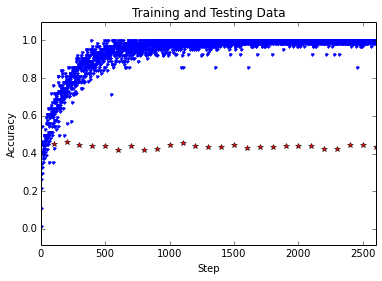

In [18]:
pyplot.plot(step_store,accuracy_store,'b.')
pyplot.plot(eval_step,eval_accuracy,'r*')
pyplot.xlim(min(step_store)-0.1,max(step_store)+0.1)
pyplot.ylim(min(accuracy_store)-0.1,max(accuracy_store)+0.1)
pyplot.xlabel("Step")
pyplot.ylabel("Accuracy")
pyplot.title("Training and Testing Data")
pyplot.show()

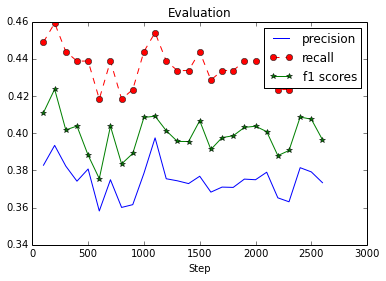

In [19]:
pyplot.plot(eval_step,eval_precision,label='precision')
pyplot.plot(eval_step,eval_recall,marker='o', linestyle='--', color='r',label='recall')
pyplot.plot(eval_step,eval_f1,marker='*', color='g',label='f1 scores')
pyplot.xlabel('Step')
pyplot.title('Evaluation')
pyplot.legend()
pyplot.show()